In [1]:
!pip install -q chess
!pip install -q tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import chess
import os
import time
import cv2
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from torchvision import transforms

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
letter_detection_model = SimpleCNN()
letter_detection_model.load_state_dict(torch.load('../models/letter_detection_model.pt', weights_only=True))
letter_detection_model.eval()
piece_detection_model = load_model("../models/model_figures.h5")

In [16]:
def are_pixels_similar(pixel1, pixel2, threshold=10):
    distance = np.linalg.norm(pixel1 - pixel2)
    return distance < threshold

def remove_lines(chess_board):
    while not are_pixels_similar(chess_board[10][0], chess_board[10][1]):  # left 
        chess_board = chess_board[:, 1:]
    while not are_pixels_similar(chess_board[0][10], chess_board[1][10]):  # top
        chess_board = chess_board[1:, :]
    while not are_pixels_similar(chess_board[-11][-1], chess_board[-11][-2]):  # right
        chess_board = chess_board[:, :-1]
    while not are_pixels_similar(chess_board[-1][-11], chess_board[-2][-11]):  # bottom
        chess_board = chess_board[:-1, :]
    return chess_board

def is_cell_empty(cell_image, threshold):
    gray_cell = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_cell, threshold, 255, cv2.ADAPTIVE_THRESH_MEAN_C)
    black_pixels = np.sum(thresh == 0)
    return black_pixels < 100

def get_player_side(cell):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((20, 20)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    height, width, _ = cell.shape
    rect_size = 28
    
    bottom_left = transform(cell[height-rect_size:height, 0:rect_size])
    bottom_right = transform(cell[height-rect_size:height, width-rect_size:width])
    
    bottom_left = bottom_left.unsqueeze(0)
    bottom_right = bottom_right.unsqueeze(0)
    
    _, predicted_bottom_left = torch.max(letter_detection_model(bottom_left).data, 1)
    _, predicted_bottom_right = torch.max(letter_detection_model(bottom_right).data, 1)

    if predicted_bottom_left == 1 or predicted_bottom_right == 1:
        return chess.WHITE
    elif predicted_bottom_left == 2 or predicted_bottom_right == 2:
        return chess.BLACK
    
def get_easy_fen(cells):
    easy_fen = ""
    string = ""
    empty_cells = 0
    for i, cell in enumerate(cells, 1):
        if cell["is_empty"]:
            empty_cells += 1
        else:
            if empty_cells > 0:
                string += f"{empty_cells}"
            string += "o"
            empty_cells = 0
        
        if i % 8 == 0:
            if empty_cells > 0:
                string += f"{empty_cells}"
            easy_fen += f"{string}/" if i < 64 else f"{string}"
            string = ""
            empty_cells = 0
    return easy_fen

def get_easy_fen_from_chessboard(chessboard):
    fen = chessboard.fen().split()[0]
    new_fen = ''.join('o' if char.isalpha() else char for char in fen)
    return new_fen

def predict_chess_piece(cell):
    figure_to_label = {
        0: 'b',
        1: 'k',
        2: 'n',
        3: 'p',
        4: 'q',
        5: 'r'
    }
    
    image_size = (224, 224)  
    cell = tf.image.resize(cell, image_size)
    cell = cell / 255.0  
    
    cell = tf.expand_dims(cell, axis=0)

    figure_tensor, color_tensor = piece_detection_model(cell)
    best_figure_idx = tf.argmax(figure_tensor, axis=1).numpy()[0]
    best_color_idx = tf.argmax(color_tensor, axis=1).numpy()[0]
    figure = figure_to_label[best_figure_idx]
    
    return figure if best_color_idx == 0 else figure.upper()
    

def set_chessboard(cells, player_side):
    initial_fens = ['rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR', 'PPPPPPPP/RNBQKBNR/8/8/8/8/rnbqkbnr/pppppppp']

    fen = ""
    string = ""
    empty_cells = 0
    for i, cell in enumerate(cells, 1):
        if cell["is_empty"]:
            empty_cells += 1
        else:
            if empty_cells > 0:
                string += f"{empty_cells}"
            string += predict_chess_piece(cell["image"])
            empty_cells = 0

        if i % 8 == 0:
            if empty_cells > 0:
                string += f"{empty_cells}"
            fen += f"{string}/" if i < 64 else f"{string}"
            string = ""
            empty_cells = 0
    
    starting_board_fen = fen        
    
    fen += f" {'w ' if player_side == chess.WHITE else 'b '}"
    fen += 'KQkq ' if starting_board_fen in initial_fens else '- '
    fen += "- 0 1"
     
    return fen


def create_easy_board(fen):
    rows = []
    for row in fen.split("/"):
        new_row = []
        for char in row:
            if char.isdigit():
                new_row.extend(["-"] * int(char))
            else:
                new_row.append(char)
        rows.append(new_row)
    return rows

def find_move(fen_before, fen_after):
    board_before = create_easy_board(fen_before)
    board_after = create_easy_board(fen_after)

    move_from = None
    move_to = None
    
    for row in range(8):
        for col in range(8):
            if board_before[row][col] != board_after[row][col]:
                if board_before[row][col] == "-":
                    move_to = f"{chr(col + ord('a'))}{str(8 - row)}"
                elif board_after[row][col] == "-":
                    move_from = f"{chr(col + ord('a'))}{str(8 - row)}"

    return move_from, move_to


def make_move(cells):
    global board
    
    easy_fen_before = get_easy_fen_from_chessboard(board)
    easy_fen_after = get_easy_fen(cells)
    
    move_from, move_to = find_move(easy_fen_before, easy_fen_after)
    
    if move_from is not None and move_to is not None:
        move = chess.Move.from_uci(move_from + move_to)
        if move in board.legal_moves:
            board.push(move)
        # TODO write else
    # TODO write else

In [17]:
def detect_split(filename):
    global board
    start_time = time.time()

    screenshot = cv2.imread(filename)
    screenshot_gray = cv2.cvtColor(screenshot, cv2.COLOR_BGR2GRAY)
    
    sigma=0.33
    v = np.mean(screenshot_gray)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    
    edges = cv2.Canny(screenshot_gray, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    
    (x, y, w, h) = cv2.boundingRect(contours[0])   
    best_area = cv2.contourArea(contours[0])    
    for i, cnt in enumerate(contours):
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        if len(approx) == 4:
            area = cv2.contourArea(cnt)
            area_diff = abs(area - best_area) / best_area
            if area_diff > 0.05:
                break
            (x, y, w, h) = cv2.boundingRect(cnt)

    
    chess_board = screenshot[y:y+h, x:x+w]
    chess_board = remove_lines(chess_board)
    chess_board = cv2.resize(chess_board, (1024, 1024))

    columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    rows = ['1', '2', '3', '4', '5', '6', '7', '8']
    step = (chess_board.shape[0]//8)
    
    # check for chessarena.com chessboard since it has wood texture. setting another threshold for emptiness of cell 
    chess_board_gray = cv2.cvtColor(chess_board, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(chess_board_gray, 160, 255, cv2.ADAPTIVE_THRESH_MEAN_C)
    black_threshold = 40 if np.sum(thresh == 0) > 700_000 else 100
    
    if board == None:
        row, col = 7, 3
        player_side = get_player_side(chess_board[row*step : (row+1)*step, col*step : (col+1)*step])
    else:
        player_side = chess.BLACK if board.turn else chess.WHITE
        
    cells = []
    for row in range(len(rows)):
        for col in range(len(columns)):
            cell_image = chess_board[row*step:(row+1)*step, col*step:(col+1)*step]
            cell_is_empty = is_cell_empty(cell_image, black_threshold)     

            if player_side == chess.WHITE:
                cell_label = f"{columns[col]}{rows[7-row]}"
            else:
                cell_label = f"{columns[7-col]}{rows[row]}" 

            cell = {"image": cell_image, "label": cell_label, "is_empty": cell_is_empty}
            cells.append(cell)
    
    if board == None:
        board = chess.Board(set_chessboard(cells, player_side))
    else:
        make_move(cells)
    print(set_chessboard(cells, player_side))
        
    print(f"Time elapsed {time.time() - start_time}")

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(chess_board, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    

In [18]:
# board = chess.Board()
board = None

rnbqkbnr/pp4pp/2p1p3/3p1p2/7P/P7/RPPPPPPR/1NBQKBN1 w - - 0 1
Time elapsed 2.875098943710327


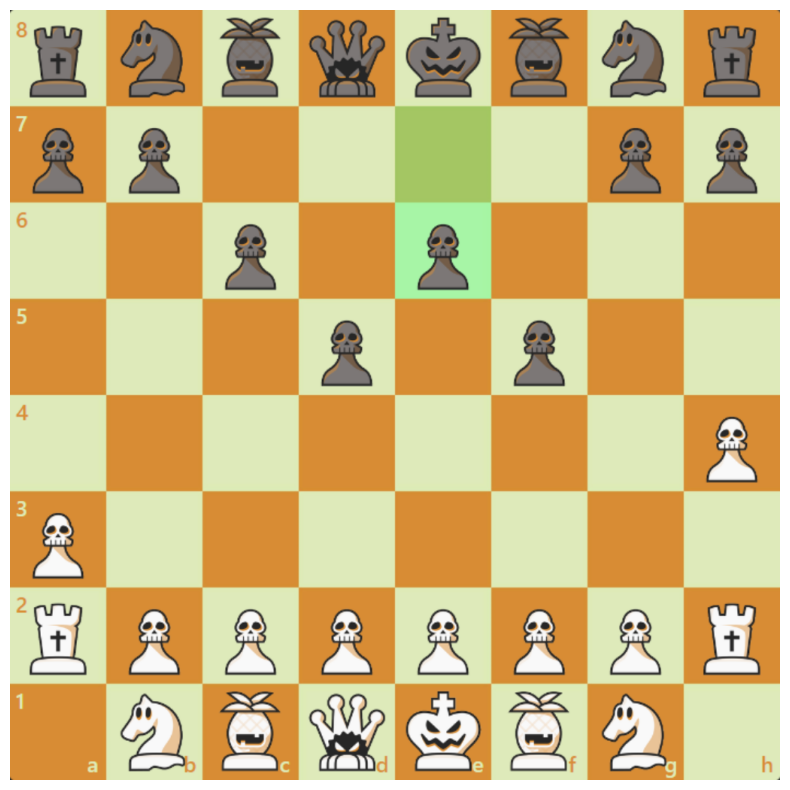

R1BKQBNR/PPP2PPP/2N5/3PP3/7p/8/pppppppr/rnbkqbn1 b - - 0 1
Time elapsed 1.208953619003296


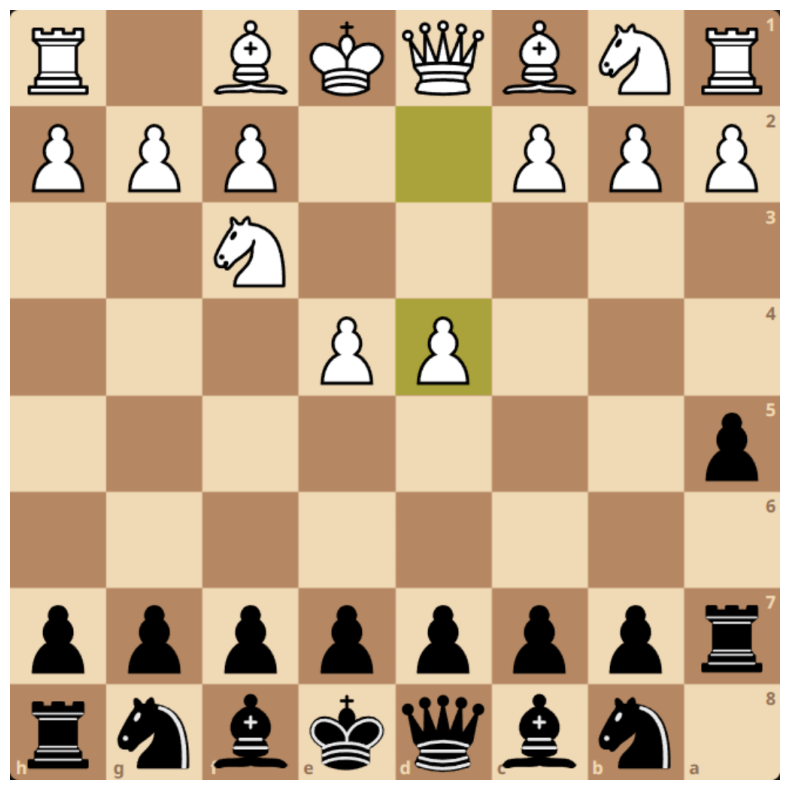

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR b KQkq - 0 1
Time elapsed 1.3147220611572266


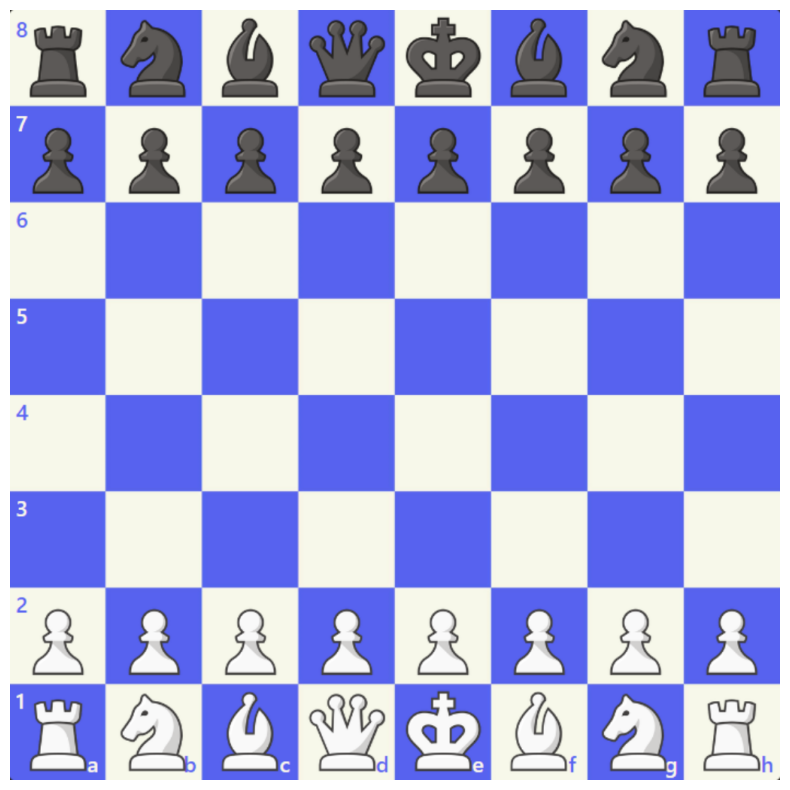

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR b KQkq - 0 1
Time elapsed 1.3300843238830566


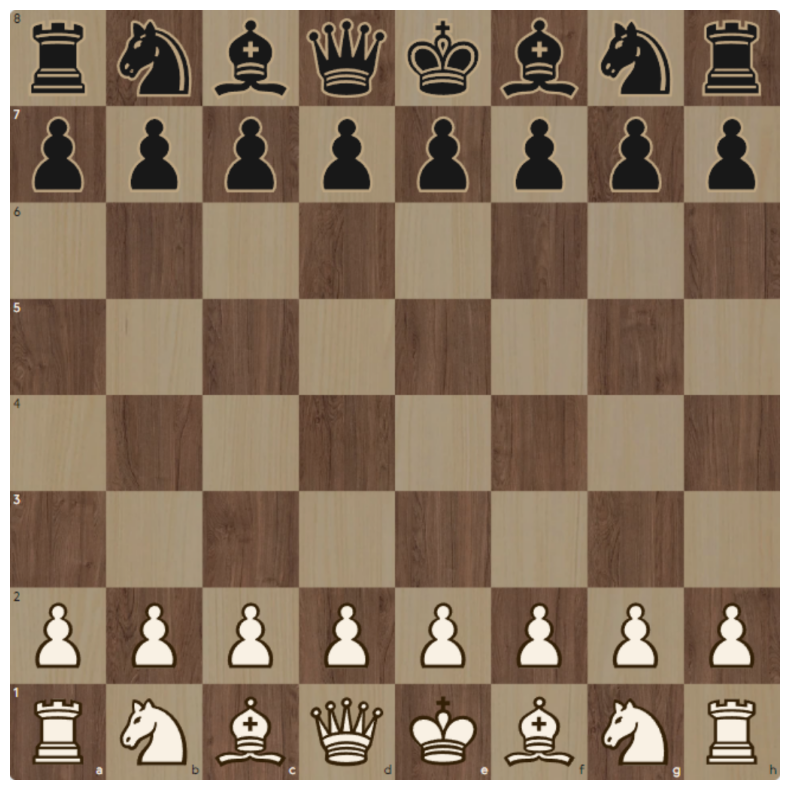

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [19]:
board_names = ["chesscom_halloween.png", "lichess_corners.png", "chesscom_discord.png", "chessarena.png", "img.png"]
for board_name in board_names:
    file_path = os.path.join("../data/sites", board_name)
    detect_split(filename=file_path)
